In [2]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import os
import sys
import time
import json
import cortex
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("{}/../../../analysis_code/utils".format(os.getcwd()))
from plot_utils import *
from pycortex_utils import draw_cortex, set_pycortex_config_file, load_surface_pycortex, create_colormap, get_rois
from surface_utils import load_surface

In [3]:
main_dir = '/Users/uriel/disks/meso_shared'
project_dir = 'RetinoMaps'

In [4]:
with open('../../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
TRs = analysis_info['TRs']
subjects = analysis_info['subjects']

In [5]:
# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)

port_num = 25000

In [6]:
# Template settings
template_specs = dict(axes_color="rgba(0, 0, 0, 1)",
                      axes_width=2,
                      axes_font_size=15,
                      bg_col="rgba(255, 255, 255, 1)",
                      font='Arial',
                      title_font_size=15,
                      plot_width=1.5)
fig_template = plotly_template(template_specs)

# vertex bar plot

## DF 

In [11]:
# Settings 
format_ = '170k'

In [9]:
# make all subject categorie proportions  df
rois_area_categorie_df = pd.DataFrame()
for subject in subjects :
    intertask_tsv_dir ='{}/{}/derivatives/pp_data/{}/{}/intertask/tsv'.format(
    main_dir, project_dir, subject, format_)
    data = pd.read_table('{}/{}_intertask-all_derivatives_{}.tsv'.format(intertask_tsv_dir, subject, suffix))
    subject_rois_area_categorie_df = pd.DataFrame()
    for roi in rois : 
        # Compute categorie proportions 
        roi_area = data.loc[data['roi'] == roi].shape[0]
        roi_area_saccade = data.loc[(data['roi'] == roi) & (data['saccade'] == 'saccade')].shape[0]
        roi_area_pursuit = data.loc[(data['roi'] == roi) & (data['pursuit'] == 'pursuit')].shape[0]
        roi_area_vision = data.loc[(data['roi'] == roi) & (data['vision'] == 'vision')].shape[0]
        roi_area_vision_and_pursuit_and_saccade = data.loc[(data['roi'] == roi) & (data['saccade'] == 'saccade') & (data['pursuit'] == 'pursuit') & (data['vision'] == 'vision'), 'vert_area'].shape[0]

        percent_saccade = ((roi_area_saccade * 100)/roi_area)
        percent_pursuit = ((roi_area_pursuit * 100)/roi_area)
        percent_vision = ((roi_area_vision * 100)/roi_area)
        percent_vision_and_pursuit_and_saccade = ((roi_area_vision_and_pursuit_and_saccade * 100)/roi_area)

        roi_area_categorie_df = pd.DataFrame({
                'subject':[subject],
                'roi': [roi],
                'saccade': [percent_saccade],
                'pursuit': [percent_pursuit],
                'vision': [percent_vision],
                'all': [percent_vision_and_pursuit_and_saccade]})


        subject_rois_area_categorie_df = pd.concat([subject_rois_area_categorie_df, roi_area_categorie_df], ignore_index=True)
    
    rois_area_categorie_df = pd.concat([rois_area_categorie_df, subject_rois_area_categorie_df], ignore_index=True)




NameError: name 'format_' is not defined

# Brain

In [6]:
# Define/create colormap
colormap_name = 'rois_colors'
colormap_dict = {'n/a': (255, 255, 255),
                 'V1': (243, 231, 155),
                 'V2': (250, 196, 132),
                 'V3': (248, 160, 126),
                 'V3AB': (235, 127, 134),
                 'LO': (150, 0, 90), 
                 'VO': (0, 0, 200),
                 'hMT+': (0, 25, 255),
                 'iIPS': (0, 152, 255),
                 'sIPS': (44, 255, 150),
                 'iPCS': (151, 255, 0),
                 'sPCS': (255, 234, 0),
                 'mPCS': (255, 111, 0)}

# create_colormap(cortex_dir=cortex_dir, 
#                 colormap_name=colormap_name, 
#                 colormap_dict=colormap_dict,
#                 recreate=True
#                )

## 170k

In [7]:
subject = 'sub-03'
format_ = '170k'
pycortex_subject = 'sub-170k'
save_svg = False

rois_dir = "{}/{}/derivatives/pp_data/{}/{}/rois".format(main_dir, project_dir, subject,format_)
roi_fn = '{}/{}_rois.dtseries.nii'.format(rois_dir, subject)
results = load_surface_pycortex(brain_fn=roi_fn)
roi_mat = results['data_concat']

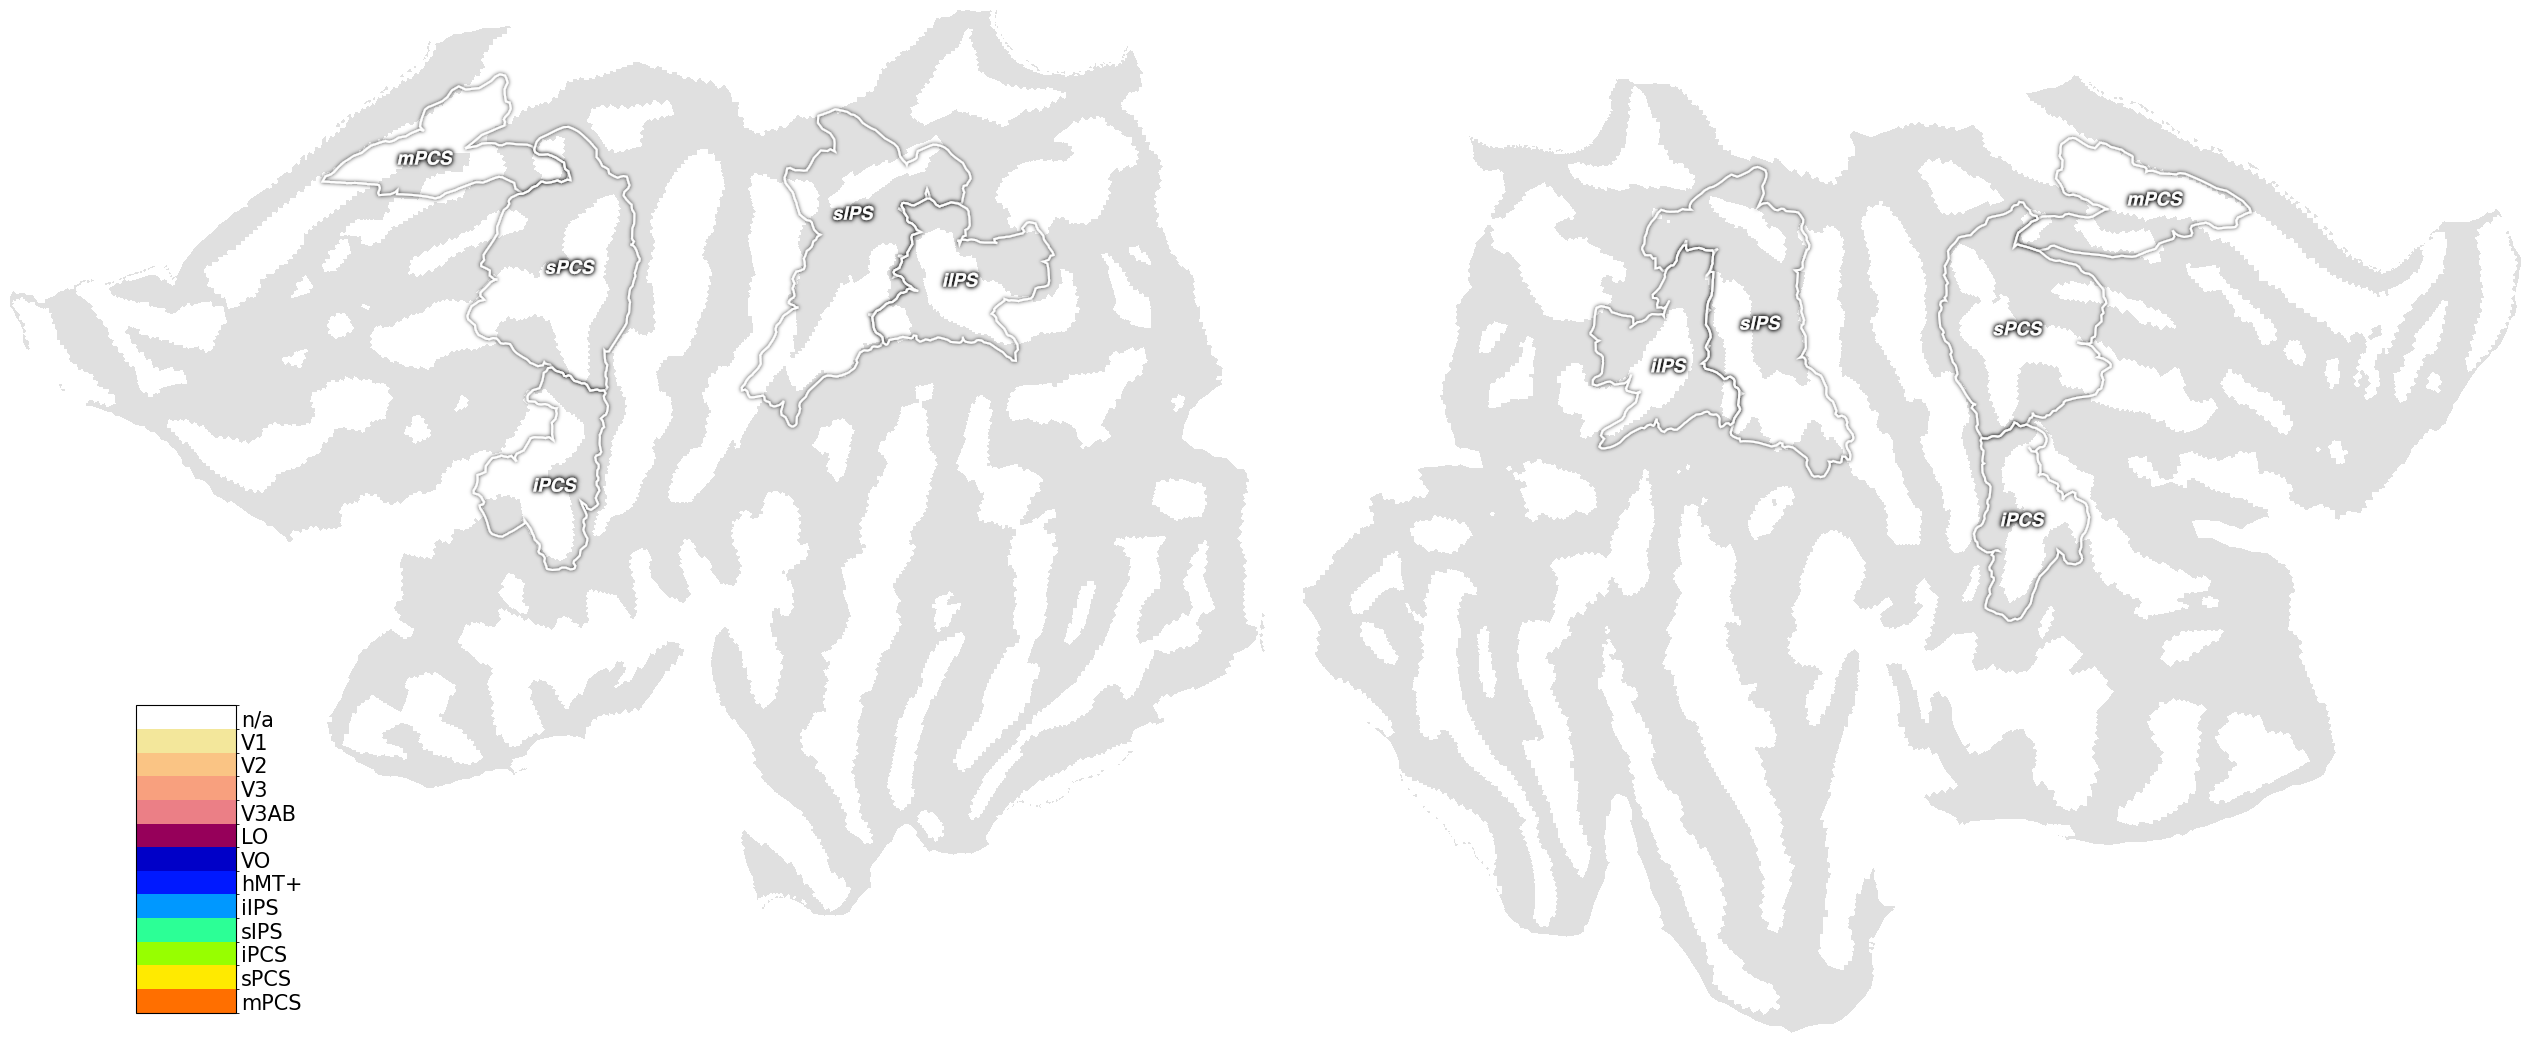

In [56]:
rois_opacity = 0

rois_dic = get_rois(subject=subject, return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp_group', surf_size='59k')
frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS']
parietal_mask = rois_dic['iIPS'] | rois_dic['sIPS']
parietal_frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS'] | rois_dic['iIPS'] | rois_dic['sIPS']

rois_mask = parietal_frontal_mask

# masks = {'frontal_mask':frontal_mask, 'parietal_mask':parietal_mask}
masks = {'parietal_frontal_mask':parietal_frontal_mask}

alpha_mat = roi_mat*0+rois_opacity
alpha_mat[roi_mat==0]=0

rois_mask = rois_mask.reshape(1,-1)
alpha_mat[~rois_mask] = 0

# rois_mask = rois_mask.reshape(1,-1)
# alpha_mat[~rois_mask] = 0
roi_name = 'brain_170k'
param_rois = {'subject': pycortex_subject,
              'data': roi_mat, 
              'cmap': colormap_name,
              'alpha': alpha_mat,
              'cbar': 'discrete_personalized', 
              'vmin': 0,
              'vmax': 12,
              'cmap_steps': len(colormap_dict),
              'cmap_dict': colormap_dict,
              'cortex_type': 'VertexRGB',
              'description': 'Gaussian pRF ROIs',
              'curv_brightness': 1, 
              'curv_contrast': 0.25,
              'add_roi': save_svg,
              'with_labels': True,
              'roi_name': roi_name}

volume_roi = draw_cortex(**param_rois)

In [57]:
port_num = port_num + 1

# Remome overlays_visible=('sulci','roi'), to have borders 
print("Go to (in 5 s...): http://localhost:{}/".format(port_num))
handle = cortex.webgl.show(data=volume_roi, recache = True, port=port_num, overlays_visible=('sulci','roi'),
    labels_visible=())


Go to (in 5 s...): http://localhost:25012/
Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 25012


In [58]:
# inflated
inflated_general = {'camera.azimuth':241,
                    'camera.altitude':60,
                    'camera.radius':430,
                    'surface.{subject}.unfold':0.5,
                    'surface.{subject}.pivot':46,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':1,
                    'surface.{subject}.specularity':0,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':1}
handle._set_view(**inflated_general)
time.sleep(5)

inflated_dir = '/Users/uriel/Downloads/'
im1 = handle.getImage('{}/inflated.png'.format(inflated_dir),size = (3000, 3000))


In [22]:
# unflated
inflated_general = {'camera.azimuth':147,
                    'camera.altitude':67,
                    'camera.radius':430,
                    'surface.{subject}.unfold':0,
                    'surface.{subject}.pivot':46,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':1,
                    'surface.{subject}.specularity':0,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':1}
handle._set_view(**inflated_general)
time.sleep(5)

inflated_dir = '/Users/uriel/Downloads/'
im1 = handle.getImage('{}/unflated_roi.png'.format(inflated_dir),size = (3000, 3000))

## MMP atlas

In [9]:
#  Load csv 
pycortex_dir = '{}/{}/derivatives/pp_data/cortex/db'.format(main_dir,project_dir)
pycortex_subject = 'sub-170k'
subject = pycortex_subject
# load npz atlas and make dataframe
mmp_atlas_fn ='{}/{}/surface-info/mmp_atlas.npz'.format(pycortex_dir, pycortex_subject)
mmp_npz = np.load(mmp_atlas_fn)

#  make left hemi 
mmp_df_lh = pd.DataFrame(mmp_npz['left'], columns = ['roi_id'])
mmp_df_lh = mmp_df_lh.assign(hemi='L')
 
#  make left hemi 
mmp_df_rh = pd.DataFrame(mmp_npz['right'], columns = ['roi_id'])
mmp_df_rh = mmp_df_rh.assign(hemi='R')


#  make brain df
mmp_df_brain = pd.concat([mmp_df_lh,mmp_df_rh], ignore_index=True )
mmp_df_brain = mmp_df_brain.assign(roi_name=np.nan)

mmp_df_brain['roi_id'] = mmp_df_brain['roi_id'].replace({0: 180})
mmp_df_brain['roi_id_hemi'] = np.where(mmp_df_brain['hemi'] == 'R', mmp_df_brain['roi_id'] + 180, mmp_df_brain['roi_id'])


In [10]:
#  Load csv 
mmp_csv_fn = '{}/{}/HCP-MMP1_UniqueRegionList.csv'.format(pycortex_dir, pycortex_subject)
mmp_csv = pd.read_csv(mmp_csv_fn)
mmp_csv['index_col'] = (mmp_csv.index + 1).astype('int32')

In [11]:
# make the final dataframe with the correpondamce between the code and the areas
mmp_final_df = pd.merge(mmp_df_brain, mmp_csv, left_on='roi_id_hemi', right_on='index_col', how='left')
mmp_final_df = mmp_final_df[['roi_id', 'roi_id_hemi', 'region','hemi']]  
mmp_final_df.rename(columns={'region': 'roi_name'}, inplace=True)

mmp_array = np.array(mmp_final_df['roi_id']).reshape(1,-1)

In [12]:
mmp_array

array([[ 34,  52,  12, ..., 133, 133, 133]], dtype=int32)

Fontconfig warning: ignoring UTF-8: not a valid region tag


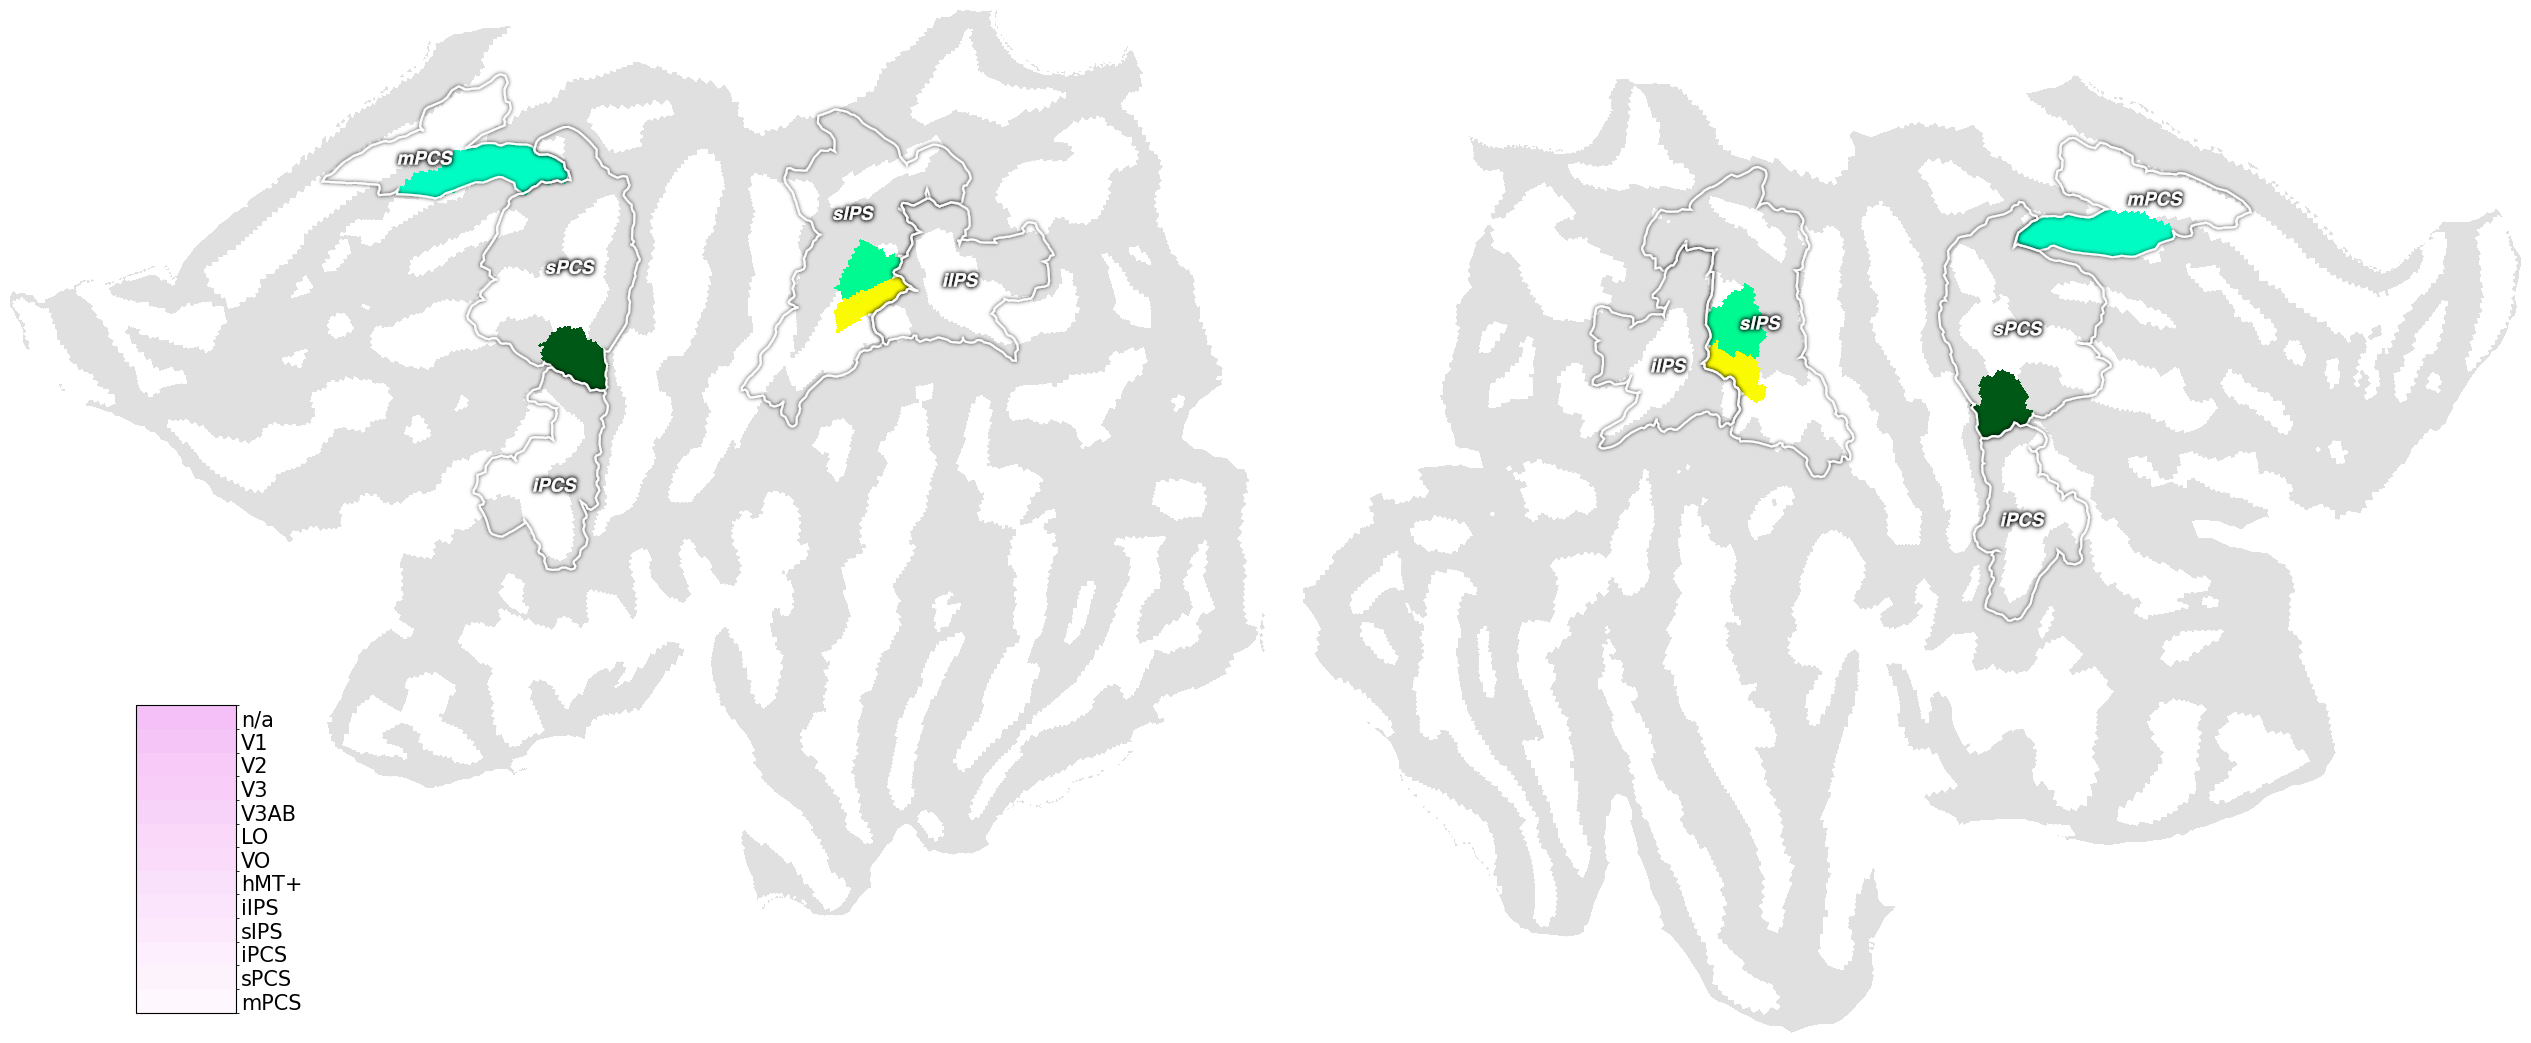

In [19]:
colormap_name = 'gist_ncar'

# vertex_data = cortex.Vertex(mmp_array, pycortex_subject, cmap=colormap_name)


rois_opacity = 1

rois_dic = get_rois(subject=subject, return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp_group', surf_size='59k')
frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS']
parietal_mask = rois_dic['iIPS'] | rois_dic['sIPS']
parietal_frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS'] | rois_dic['iIPS'] | rois_dic['sIPS']

rois_cibles = ["LIPv", "LIPd", "FEF", "SCEF"]
eye_mvt_mask = np.array(mmp_final_df["roi_name"].isin(rois_cibles))

rois_mask = eye_mvt_mask

# masks = {'frontal_mask':frontal_mask, 'parietal_mask':parietal_mask}
masks = {'parietal_frontal_mask':parietal_frontal_mask}

alpha_mat = mmp_array*0+rois_opacity
alpha_mat[mmp_array==0]=0

rois_mask = rois_mask.reshape(1,-1)
alpha_mat[~rois_mask] = 0

# rois_mask = rois_mask.reshape(1,-1)
# alpha_mat[~rois_mask] = 0
roi_name = 'brain_170k'
param_rois = {'subject': pycortex_subject,
              'data': mmp_array, 
              'cmap': colormap_name,
              'alpha': alpha_mat,
              'cbar': 'discrete_personalized', 
              'vmin': 0,
              'vmax': 180,
              'cmap_steps': 180,
              'cmap_dict': colormap_dict,
              'cortex_type': 'VertexRGB',
              'description': 'Gaussian pRF ROIs',
              'curv_brightness': 1, 
              'curv_contrast': 0.25,
              'add_roi': False,
              'with_labels': True,
              'roi_name': roi_name}

volume_roi = draw_cortex(**param_rois)



In [27]:
port_num = port_num + 1

# Remome overlays_visible=('sulci','roi'), to have borders 
print("Go to (in 5 s...): http://localhost:{}/".format(port_num))
handle = cortex.webgl.show(data=volume_roi, recache = True, port=port_num, #overlays_visible=('sulci','roi'),
    labels_visible=())

# _all_rois

Go to (in 5 s...): http://localhost:25004/
Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 25004


In [28]:
# inflated
inflated_general = {'camera.azimuth':241,
                    'camera.altitude':60,
                    'camera.radius':430,
                    'surface.{subject}.unfold':0.5,
                    'surface.{subject}.pivot':46,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':1,
                    'surface.{subject}.specularity':0,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':1}
handle._set_view(**inflated_general)
time.sleep(5)

inflated_dir = '/Users/uriel/Downloads/'
im1 = handle.getImage('{}/inflated_mmp.png'.format(inflated_dir),size = (3000, 3000))

## Fsnative

In [59]:
subject = 'sub-03'
format_ = 'fsnative'
pycortex_subject = subject
save_svg = False

rois_dir = "{}/{}/derivatives/pp_data/{}/{}/rois".format(main_dir, project_dir, subject,format_)
roi_L_fn = '{}/{}_hemi-L_rois.func.gii'.format(rois_dir, subject)
roi_R_fn = '{}/{}_hemi-R_rois.func.gii'.format(rois_dir, subject)
results = load_surface_pycortex(L_fn=roi_L_fn, R_fn=roi_R_fn)
roi_mat = results['data_concat']

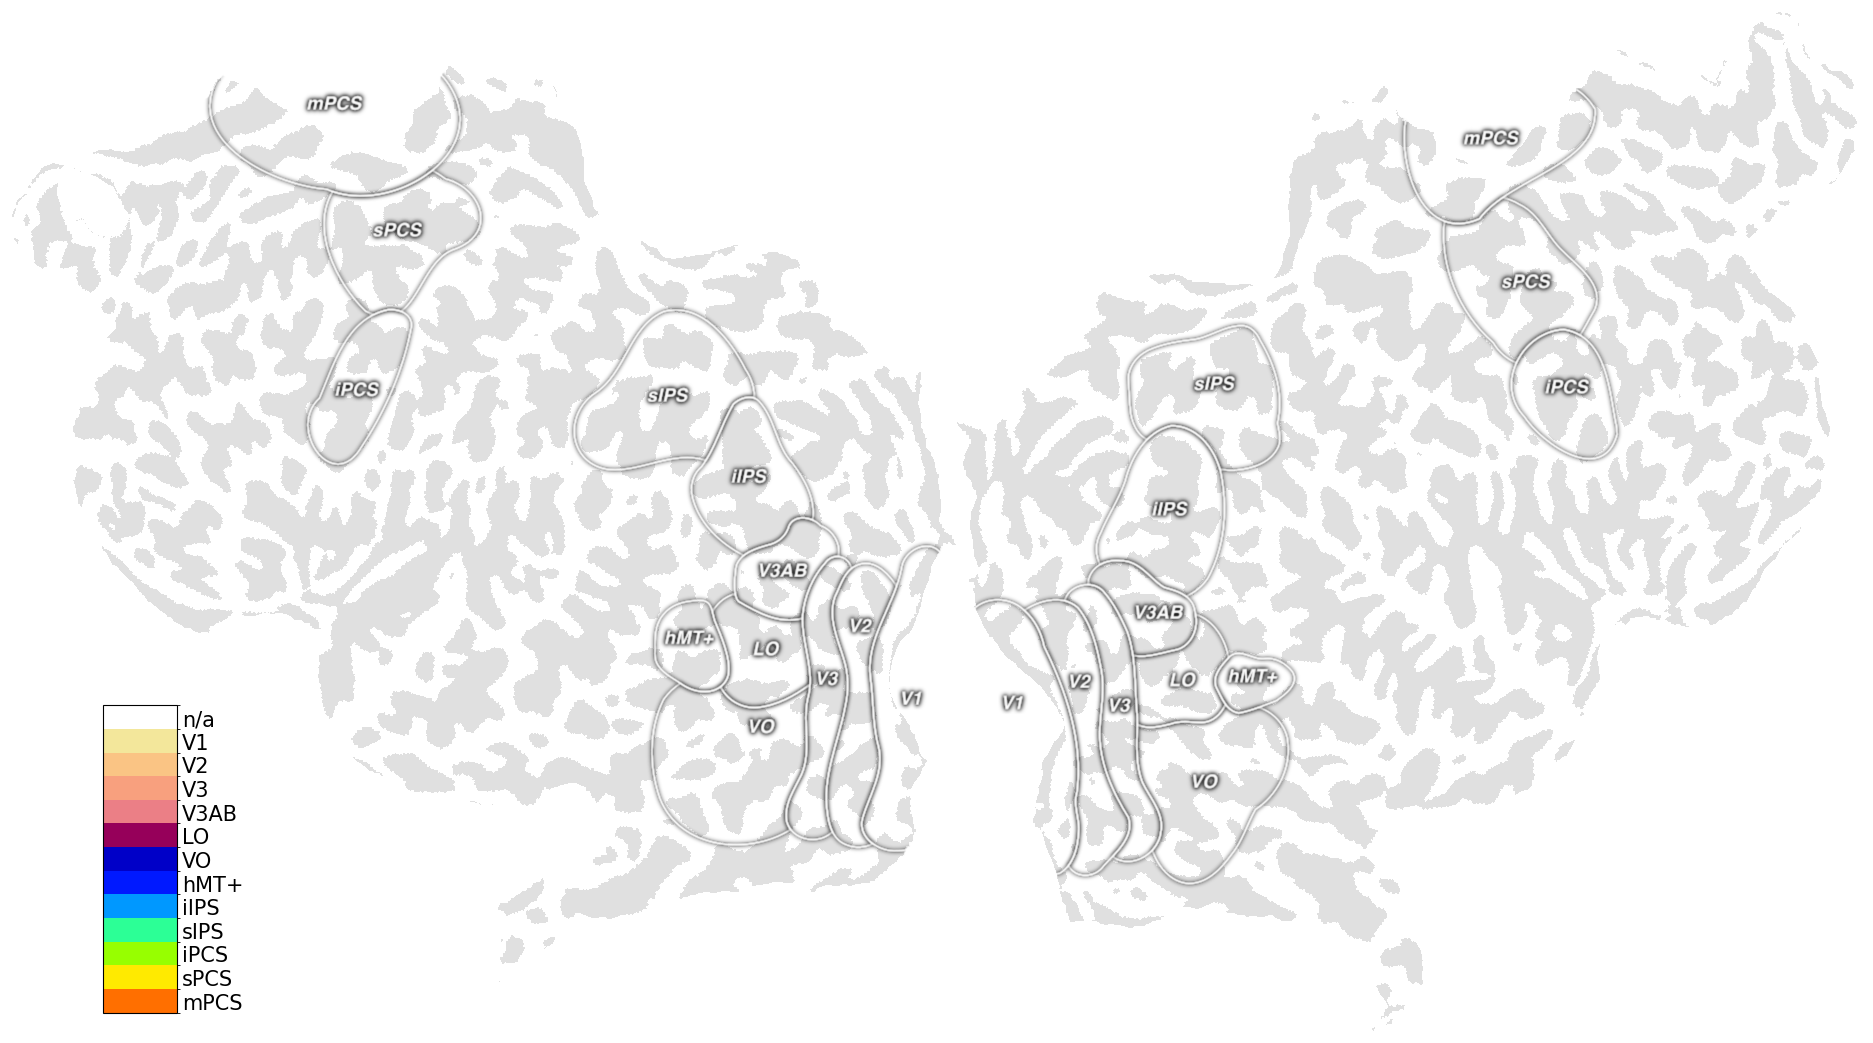

In [60]:
rois_opacity = 0

alpha_mat = roi_mat*0+rois_opacity
alpha_mat[roi_mat==0]=0

# rois_mask = rois_mask.reshape(1,-1)
# alpha_mat[~rois_mask] = 0
roi_name = 'brain_170k'
param_rois = {'subject': pycortex_subject,
              'data': roi_mat, 
              'cmap': colormap_name,
              'alpha': alpha_mat,
              'cbar': 'discrete_personalized', 
              'vmin': 0,
              'vmax': 12,
              'cmap_steps': len(colormap_dict),
              'cmap_dict': colormap_dict,
              'cortex_type': 'VertexRGB',
              'description': 'Gaussian pRF ROIs',
              'curv_brightness': 1, 
              'curv_contrast': 0.25,
              'add_roi': save_svg,
              'with_labels': True,
              'roi_name': roi_name}

volume_roi = draw_cortex(**param_rois)

In [61]:
port_num = port_num + 1
print("Go to (in 5 s...): http://localhost:{}/".format(port_num))
handle = cortex.webgl.show(data=volume_roi, recache = True, port=port_num, overlays_visible=('sulci','roi'),
    labels_visible=())

Go to (in 5 s...): http://localhost:25013/
Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 25013


In [63]:
# inflated
inflated_general = {'camera.azimuth':241,
                    'camera.altitude':60,
                    'camera.radius':430,
                    'surface.{subject}.unfold':0.5,
                    'surface.{subject}.pivot':46,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':1,
                    'surface.{subject}.specularity':0,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':1}
handle._set_view(**inflated_general)
time.sleep(5)

inflated_dir = '/Users/uriel/Downloads/'
im1 = handle.getImage('{}/inflated.png'.format(inflated_dir),size = (3000, 3000))


# Eye movments target

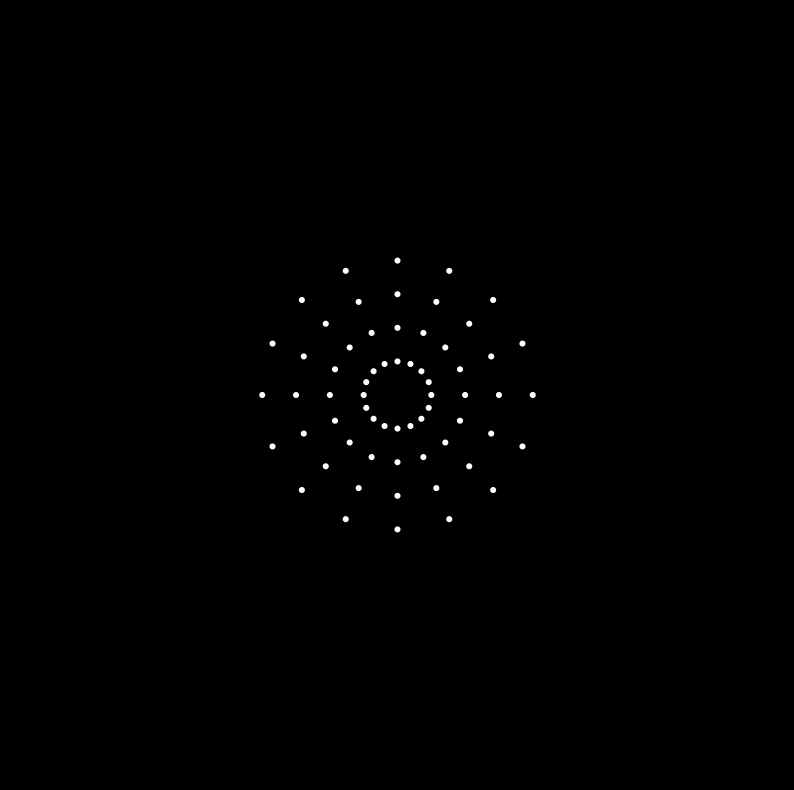

In [12]:
def create_image(eccentricities_degrees, num_directions=16, circle_size=0.02, figure_size=(4, 4), final_size=(8.2, 14.58)):
    # Créer une figure et un axe avec une taille personnalisée
    fig, ax = plt.subplots(figsize=figure_size)
    
    # Définir le fond noir
    fig.patch.set_facecolor('black')
    ax.set_facecolor('black')

    # Définir les coordonnées du centre
    center = np.array([0.5, 0.5])

    # Conversion des excentricités de degrés en radians
    eccentricities_radians = np.radians(eccentricities_degrees)

    # Créer les cercles avec des ronds blancs pour chaque excentricité
    for eccentricity in eccentricities_radians:
        for direction in range(num_directions):
            angle = (2 * np.pi / num_directions) * direction
            x = center[0] + eccentricity * np.cos(angle)
            y = center[1] + eccentricity * np.sin(angle)

            # Dessiner le cercle blanc
            circle = plt.Circle((x, y), circle_size, color='white')
            ax.add_artist(circle)

    # Paramètres d'affichage
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    # Sauvegarder l'image avec la taille finale en centimètres
    fig.savefig('/Users/uriel/Downloads/cercles.png', bbox_inches='tight', pad_inches=0, dpi=300)

# Excentricités en degrés
eccentricities_degrees = [10, 7.5, 5, 2.5]

# Taille du cercle réduite et taille de la figure personnalisée
create_image(eccentricities_degrees, circle_size=0.003, figure_size=(10, 10))


# Time series

## Functions 

In [6]:
def gaus_2d_css(gauss_x, gauss_y, gauss_sd, n, screen_side, grain=200):
    """
    Generate 2D Gaussian mesh with CSS model
    
    Parameters
    ----------
    gauss_x : mean x Gaussian parameter in dva (e.g. 1 dva)
    gauss_y : mean y Gaussian parameter in dva (e.g. 1 dva)
    gauss_sd : sd Gaussian parameter in dva (e.g. 1 dva)
    screen_side : mesh screen side (square) in dva (e.g. 20 dva from -10 to 10 dva)
    n : exponent parameter of the CSS model
    grain : grain resolution of the mesh in pixels (default = 200 pixels)
    
    Returns
    -------
    x : linspace x of the mesh
    y : linspace y of the mesh
    z : mesh_z values (to plot)
    
    """
    x = np.linspace(-screen_side/2, screen_side/2, grain)
    y = np.linspace(-screen_side/2, screen_side/2, grain)
    mesh_x, mesh_y = np.meshgrid(x, y)
    
    gauss_z = 1./(2.*np.pi*gauss_sd*gauss_sd) * np.exp(-((mesh_x-gauss_x)**2./(2.*gauss_sd**2.) + (mesh_y-gauss_y)**2./(2.*gauss_sd**2.)))
    
    # Apply the CSS model by raising the Gaussian to the power of n
    gauss_z_css = gauss_z ** n
    
    return x, y, gauss_z_css


In [34]:
def draw_timeseries(bold_data, prf_prediction, vox_data, vox_model, TRs, roi):
    
    # # compute r2 if voxel of model and of data are different
    # if vox_data != vox_model:
    #     r2_val = pingouin.corr(df.data_fs[vox_data], df.pred_fs[vox_model]).iloc[0]['r']**2
    # else:
    #     r2_val = df.r2_fs[vox_model]
    
    
    # General figure settings
    fig_template = plotly_template(template_specs)
    
    # Subplot settings
    rows, cols = 2, 2
    margin_t, margin_b, margin_l, margin_r = 50, 50 ,50 ,50
    fig_ratio = 5
    fig_height = 1080/fig_ratio + (1080/fig_ratio*0.15) + margin_t+margin_b
    fig_width = 1920/fig_ratio + 1920/fig_ratio + margin_l+margin_r
    column_widths,row_heights = [1,1],[0.15,1]
    sb_specs = [[{},{}],[{},{}]]
    hover_data = 'Time: %{x:1.2f} s<br>' + 'z-score: %{y:1.2f}'
    hover_model = 'Time: %{x:1.2f} s<br>' + 'z-score: %{y:1.2f}'

    xaxis_range = [0,250]
    yaxis_range = [-2,3]
    yaxis_dtick = 1
    x_tickvals = np.linspace(0,208,6)*TR
    
    lwd_mot = np.array([ 114*TR,  142*TR, 0.5,  0.5])
    dwd_mot = np.array([ 80*TR, 80*TR, 0.85,  0.15])
    rwd_mot = np.array([ 46*TR,  18*TR, 0.5, 0.5])
    uwd_mot = np.array([176*TR, 176*TR, 0.15, 0.85])
    
    x0_all = np.array([0,16,48,64,96,112,144,160,192])*TR
    x1_all = np.array([16,48,64,96,112,144,160,192,208])*TR
    
    rolling = 3
    data_col = 'rgba(0, 0, 0, 1)'
    model_col = 'rgba(200, 0, 0, 1)'
    # subplot_titles = ['<b>{} time series </b> ({})'.format(roi, subject),'','','']
    subplot_titles = ''
    screen_side = 10*2
    # prf_xrange = [-8.9,8.9]
    # prf_yrange = [-5,5]
    prf_xrange = [-10,10]
    prf_yrange = [-10,10]    
    
    x_par_txt = -10
    y_par_text = 9
    
    # avg to have less points
    bold_data_reshaped = bold_data.reshape(104, 2, -1)
    bold_data_mean = np.mean(bold_data_reshaped, axis=1)
    
    prf_pred_data_reshaped = prf_pred_data.reshape(104, 2, -1)
    prf_pred_data_mean = np.mean(prf_pred_data_reshaped, axis=1)
    # create figure
    fig = make_subplots(rows=rows, cols=cols, specs=sb_specs, print_grid=False, vertical_spacing=0.05, horizontal_spacing=0.05, 
                        column_widths=column_widths, row_heights=row_heights,  subplot_titles=subplot_titles)

    # Timeseries stim
    for x0,x1 in zip(x0_all,x1_all):
        fig.add_shape(type='rect', xref='x', yref='y', x0=x0, y0=0, x1=x1, y1=1, 
                      line_width=2, fillcolor='black', line_color='white')
        
    for [coord_tp] in zip([rwd_mot, dwd_mot, lwd_mot, uwd_mot]):
        fig.add_annotation(ax=coord_tp[0], x=coord_tp[1], ay=coord_tp[2], y=coord_tp[3], 
                           xref='x', yref='y', axref='x',ayref='y',
                           text='', showarrow=True, arrowhead=2, arrowcolor='white')


    # time series data
    fig.append_trace(go.Scatter(x=np.linspace(0,TRs*TR,104), 
                                y=bold_data_mean[:,vox_data],                        
                                name='<i>data<i>',
                                showlegend=False, mode='markers', marker_color=data_col,
                                hovertemplate=hover_data,
                                line_width=0, opacity=1, marker_size=6),row=2, col=1)
    # time series predictions
    fig.append_trace(go.Scatter(x=np.linspace(0,TRs*TR,104), 
                                y=prf_pred_data_mean[:,vox_model],
                                name='<i>model<i>',
                                showlegend=False, mode='lines', line_color='orange', 
                                hovertemplate=hover_model,
                                line_width=2, opacity=1),row=2, col=1)

    # pRF heatmap
    x,y,z = gaus_2d_css(gauss_x=prf_fit_data[x_idx,vox_model], gauss_y=prf_fit_data[y_idx,vox_model], 
                gauss_sd=prf_fit_data[size_idx,vox_model], n=prf_fit_data[n_idx,vox_model], screen_side=screen_side)
    
    
    fig.append_trace(go.Heatmap(x=x, y=y, z=z,colorscale='viridis', showscale=False, hoverinfo='none'),row=2,col=2)

    fig.add_annotation(x=prf_fit_data[x_idx,vox_model], ax=prf_fit_data[x_idx,vox_model], y=prf_yrange[0], ay=prf_yrange[0]-0.5,
                       xref='x4', yref='y4', axref='x4',ayref='y4', yanchor="top", showarrow=True,
                       text='<i>pRFx</i> = {:1.2g}°'.format(prf_fit_data[x_idx,vox_model]), arrowhead=2, arrowwidth=2.5)

    fig.add_annotation(x=prf_xrange[1], ax=prf_xrange[1]+0.5, y=prf_fit_data[y_idx,vox_model], ay=prf_fit_data[y_idx,vox_model],
                       xref='x4', yref='y4', axref='x4',ayref='y4', yanchor="top", showarrow=True, 
                       text='<i>pRFy</i> = {:1.2g}°'.format(prf_fit_data[y_idx,vox_model]), textangle=-90, arrowhead=2, arrowwidth=2.5)
    
    fig.add_shape(type='line', xref='x4', yref='y4', x0=prf_xrange[0], x1=prf_xrange[1], y0=prf_fit_data[y_idx,vox_model], y1=prf_fit_data[y_idx,vox_model], 
                      line_width=2, line_color='white', line_dash='dot')
    
    fig.add_shape(type='line', xref='x4', yref='y4', x0=prf_fit_data[x_idx,vox_model], x1=prf_fit_data[x_idx,vox_model], y0=prf_yrange[0], y1=prf_yrange[1], 
                      line_width=2, line_color='white', line_dash='dot')     
    
    fig.add_annotation(x=x_par_txt, y=y_par_text, xref='x4', yref='y4', xanchor="left", font_color='white', showarrow=False,
                       text='<i>pRF loo R<sup>2</sup></i> = {:1.2g}'.format(prf_fit_data[r2_idx,vox_model]))
    
    fig.add_annotation(x=x_par_txt, y=y_par_text-1.5, xref='x4', yref='y4', xanchor="left", font_color='white', showarrow=False,
                       text='<i>pRF size</i> = {:1.2g}°'.format(prf_fit_data[size_idx,vox_model]))
    
    fig.add_annotation(x=x_par_txt, y=y_par_text-3, xref='x4', yref='y4',  xanchor="left", font_color='white', showarrow=False, 
                       text='<i>pRF ecc</i> = {:1.2g}°'.format(prf_fit_data[ecc_idx,vox_model]))
    
    fig.add_annotation(x=x_par_txt, y=y_par_text-4.5, xref='x4', yref='y4',  xanchor="left", font_color='white', showarrow=False, 
                       text='<i>pRF angle</i> = {:3.0f}°'.format(np.angle(prf_fit_data[x_idx,vox_model] + 1j * prf_fit_data[y_idx,vox_model],deg=True)))

    # set axis
    for row in np.arange(rows):
        for col in np.arange(cols):
            fig.update_xaxes(visible=True, ticklen=8, linewidth=template_specs['axes_width'], row=row+1, col=col+1)
            fig.update_yaxes(visible=True, ticklen=8, linewidth=template_specs['axes_width'], row=row+1, col=col+1)
            
    fig.update_xaxes(scaleanchor="y4", scaleratio=1, row=2, col=2)
    fig.update_yaxes(scaleanchor="x4", scaleratio=1, row=2, col=2)
    fig.layout.update(xaxis_range=xaxis_range, xaxis_title='', 
                      xaxis_visible=False, yaxis_visible=False,
                      yaxis_range=[0,1], yaxis_title='',
                      xaxis4_range=prf_xrange, xaxis4_title='', 
                      yaxis4_range=prf_yrange, yaxis4_title='', 
                      xaxis4_visible=False, yaxis4_visible=False,
                      xaxis3_tickvals=x_tickvals, xaxis3_ticktext=np.round(x_tickvals),
                      xaxis3_range=xaxis_range, #xaxis3_title='Time (seconds)',
                      yaxis3_range=yaxis_range, #yaxis3_title='z-score',
                      yaxis3_dtick=yaxis_dtick,
                      template=fig_template, width=fig_width, height=fig_height, 
                      margin_l=margin_l+10, margin_r=margin_r-10, margin_t=margin_t-20, margin_b=margin_b+20,
                      legend_yanchor='top', legend_y=0.85, legend_xanchor='left', 
                      legend_x=0.02, legend_bgcolor='rgba(255,255,255,0)')

    return fig

## Plot 

In [8]:
subject = 'sub-03'
format_ = 'fsnative'
extension = 'func.gii'

In [13]:
bold_dir = '{}/{}/derivatives/pp_data/{}/{}/func/fmriprep_dct_loo_avg'.format(main_dir, project_dir,subject,format_)
bold_fn = '{}/{}_task-pRF_hemi-L_fmriprep_dct_avg_loo-1_bold.{}'.format(bold_dir, subject, extension)
bold_img, bold_data = load_surface(fn = bold_fn)

In [14]:
prf_dir ='{}/{}/derivatives/pp_data/{}/{}/prf/fit/'.format(main_dir, project_dir,subject,format_)
prf_pred_fn = '{}/{}_task-pRF_hemi-L_fmriprep_dct_avg_loo-1_prf-pred_css.func.gii'.format(prf_dir, subject)
prf_pred_img, prf_pred_data = load_surface(fn = prf_pred_fn)

In [15]:
ecc_idx, size_idx, x_idx, y_idx, n_idx, r2_idx = 1,4,7,8,11,12

prf_deriv_dir = '{}/{}/derivatives/pp_data/{}/{}/prf/prf_derivatives'.format(main_dir, project_dir,subject,format_)
prf_fit_fn = '{}/{}_task-pRF_hemi-L_fmriprep_dct_avg_loo-1_prf-deriv_css.func.gii'.format(prf_deriv_dir, subject)
prf_fit_img, prf_fit_data = load_surface(fn = prf_fit_fn)

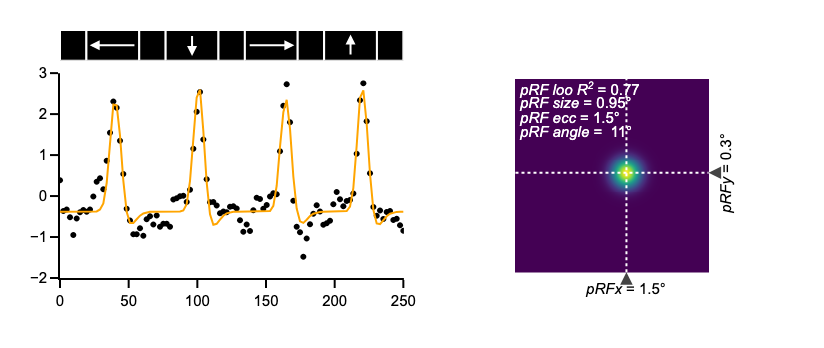

In [35]:
vertex_to_plot = 9383

fig = draw_timeseries(bold_data=bold_data, prf_prediction=prf_pred_data, vox_data=vertex_to_plot, vox_model=vertex_to_plot, TRs=TRs, roi='V1')
fig.write_image('/Users/uriel/Downloads/time_seris.pdf')
fig.show()